# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
import os
from google.colab import drive

import re
import numpy as np
import pandas as pd
import time

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
from  wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  GroupShuffleSplit #,  train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics.pairwise import cosine_distances

import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision import transforms
import torchvision.models as models
from torchvision.models import resnet18,ResNet18_Weights

import matplotlib.pyplot as plt
from PIL import Image



In [2]:
np.random.seed(4999)
rmse = lambda x,y: mean_squared_error(x,y,squared=False)
rmse.__name__ = 'RMSE'
cosine = lambda x,y : cosine_distances([x],[y]).flatten()
rmse.__name__ = 'Cosine'


In [3]:
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/Colab Notebooks/29_search_by_pictures")
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks/29_search_by_pictures'

In [4]:
expr = pd.read_csv('datasets/ExpertAnnotations.tsv',
                   sep='\t',
                   names=['image','query_id','est1','est2','est3']
                   )#.set_index('query_id')
expr.info()
expr.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   est1      5822 non-null   int64 
 3   est2      5822 non-null   int64 
 4   est3      5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


,image,query_id,est1,est2,est3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [5]:
crwd = pd.read_csv('datasets/CrowdAnnotations.tsv',
                   sep='\t',
                   names=['image','query_id','ratio','n_yes','n_no'])
#                   )#.set_index('query_id')
crwd.info()
crwd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   ratio     47830 non-null  float64
 3   n_yes     47830 non-null  int64  
 4   n_no      47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


,image,query_id,ratio,n_yes,n_no
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [6]:
crwd.query_id.value_counts().count()

1000

In [7]:
crwd.duplicated().sum()

0

In [8]:
combo = crwd.merge(expr,on=['query_id','image'],how = 'outer')
combo.info()
print( 'combo keys duplicates: ', combo[['image','query_id']].duplicated().sum())
print('both expert and crowd estimates: ',combo[['est1','ratio']].notna().all(axis=1).sum())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     51323 non-null  object 
 1   query_id  51323 non-null  object 
 2   ratio     47830 non-null  float64
 3   n_yes     47830 non-null  float64
 4   n_no      47830 non-null  float64
 5   est1      5822 non-null   float64
 6   est2      5822 non-null   float64
 7   est3      5822 non-null   float64
dtypes: float64(6), object(2)
memory usage: 3.5+ MB
combo keys duplicates:  0
both expert and crowd estimates:  2329


In [9]:
tr = pd.read_csv(f"datasets/train_dataset.csv")#.set_index('query_id')
tr.info()
tr

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


In [10]:
# te = pd.read_csv(f"datasets/test_queries.csv",sep='|').iloc[:,1:]#.set_index('query_id')
# te

In [11]:
tr.isna().sum()

image         0
query_id      0
query_text    0
dtype: int64

In [12]:
tr.duplicated().sum()

0

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [13]:
%%time
nltk.download('stopwords')
stopwords = list(set(nltk_stopwords.words('english'))) + [chr(x) for x in  range(0x21,0x40)]

nltk.download('wordnet')
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


CPU times: user 1.25 s, sys: 59.8 ms, total: 1.31 s
Wall time: 2.3 s


In [14]:
%%time
sentence1 = "The striped bats are hanging, jumping on their feet for a best"
sentence2 = "you should be ashamed of yourself went worked"

def lemmatize(text):
    tokens  = [ t.lemma_ for t in nlp(text) if t.lemma_ not in stopwords ]
    return " ".join([token for token in tokens if token not in stopwords])
print( lemmatize(sentence1),lemmatize(sentence2) )


stripe bat hang jump foot good ashamed go work
CPU times: user 20.6 ms, sys: 999 µs, total: 21.6 ms
Wall time: 62.4 ms


In [15]:
def get_lemmas(df,field='query_text'):
    df['lemmas'] = df[field].apply(lemmatize)
    return df

In [16]:
tr = get_lemmas(tr)
tr.sample(10).lemmas.apply(lambda st: print(f" {st:.99s}") );
pass

 young boy ride bike
 man windsurf ocean
 child sit front computer teacher instruct
 dog lie tether side mirror yellow VW bus
 three man three dog float yellow boat
 man uniform play black dog
 little boy navy blue run fast
 football player talk coach
 soccer player jump air game
 child sled mound snow watch


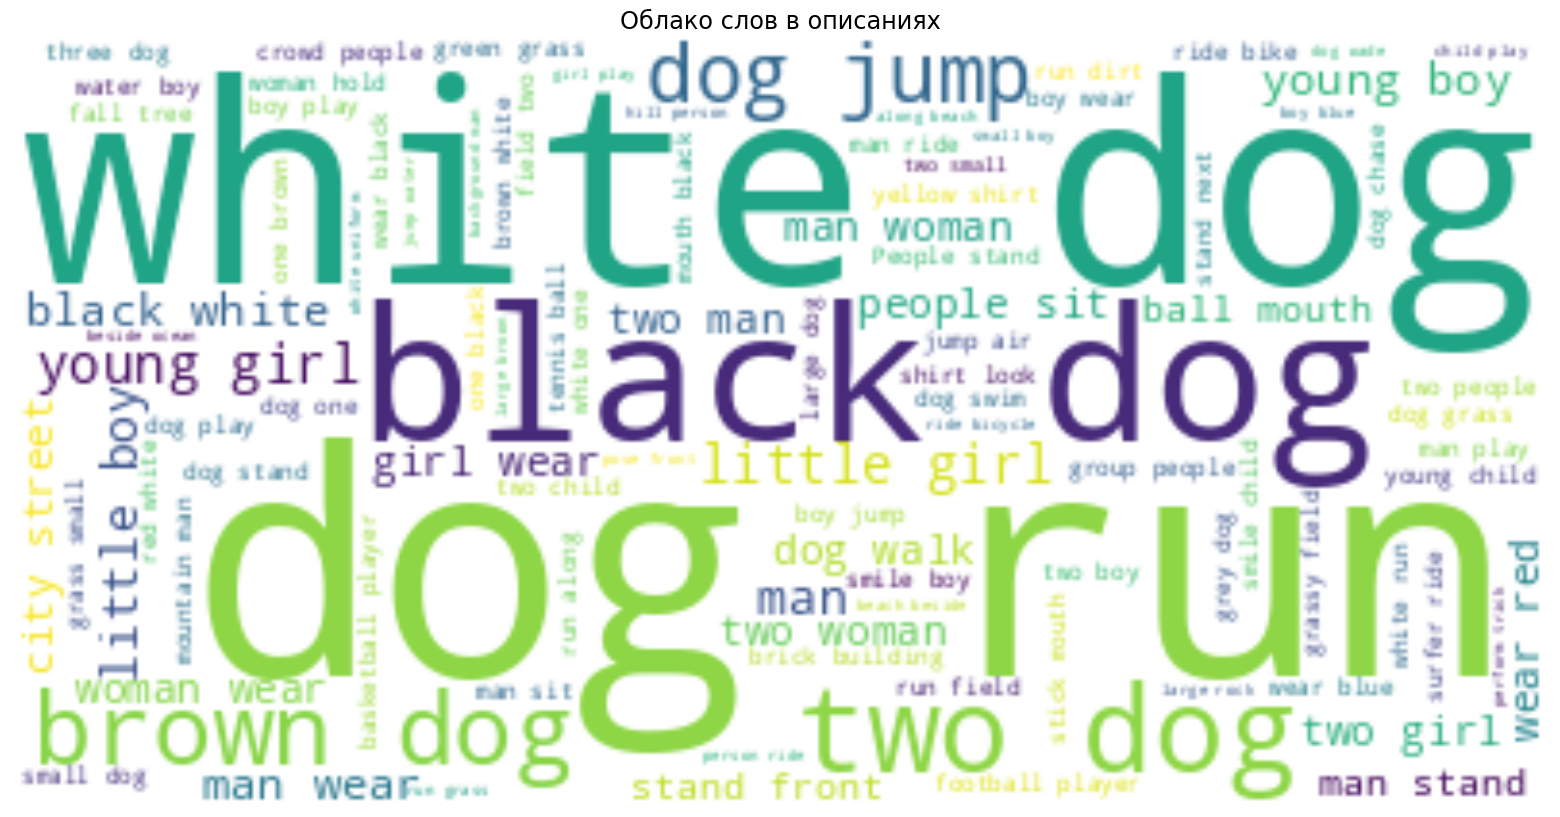

CPU times: user 1.39 s, sys: 84.3 ms, total: 1.48 s
Wall time: 1.52 s


In [17]:
%%time

def show_wordcloud(serie,repeat=False,title = 'Frequency of words'):
    wcl = WordCloud(background_color="white")
    wcl.generate(' '.join(serie.values))
    plt.figure(figsize=(20,10))
    plt.axis("off")
    plt.title(title,fontsize='xx-large')

    plt.imshow(wcl, interpolation="bilinear")
    plt.show()


show_wordcloud(tr.lemmas,title='Облако слов в описаниях')

In [18]:
child_words= {'boy','girl','child','baby','teen','young'}
def contain_words(str_, set_):
    return bool( set(str_.split()) & set_ )
images_to_delete =  tr[tr.lemmas.apply(contain_words ,set_= child_words )].query_id.apply(lambda s: s[:-2]).unique()



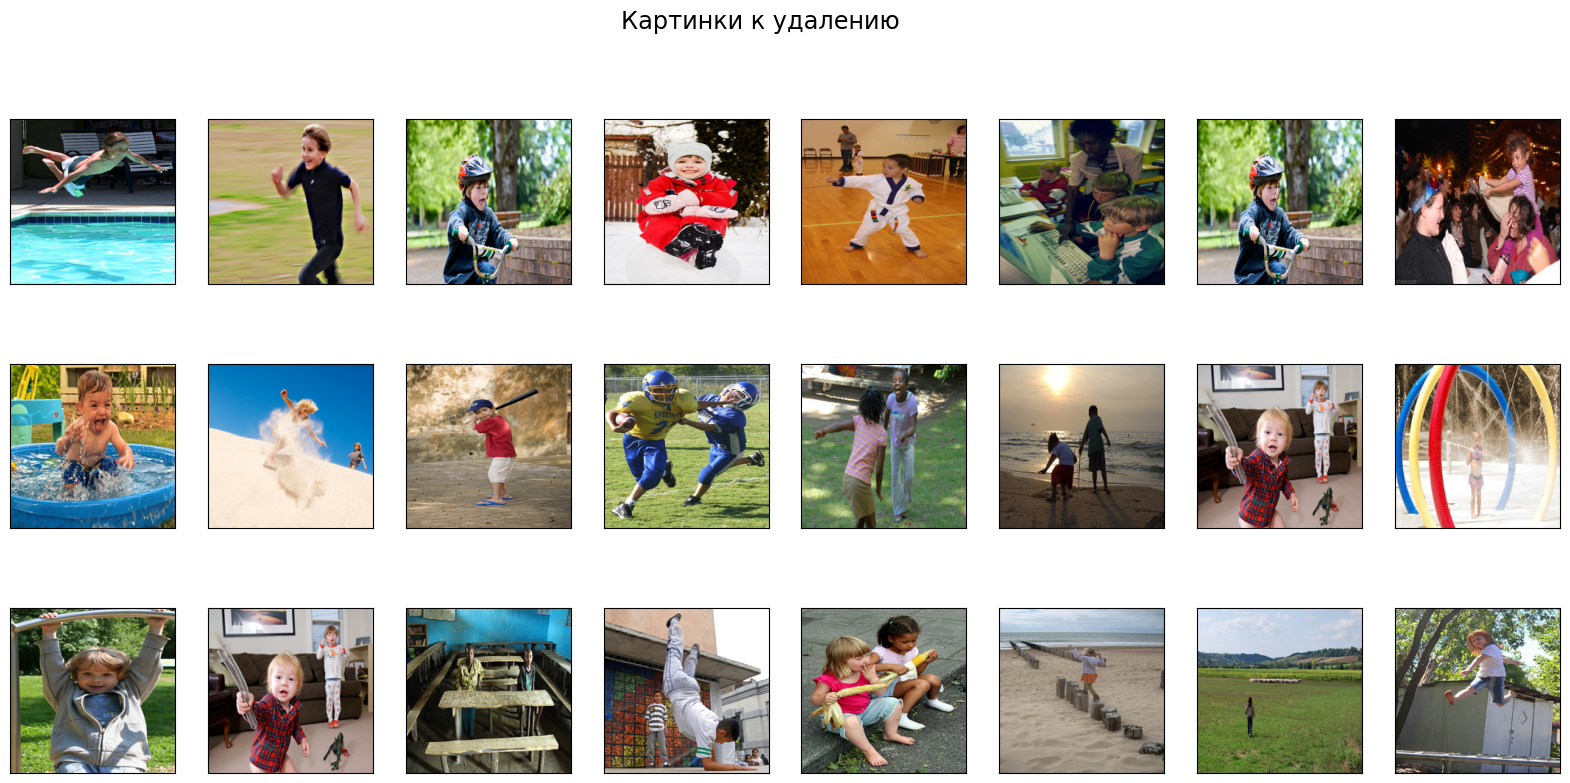

In [19]:
figure,axs = plt.subplots(3,8,figsize=(20,9) )
plt.suptitle( 'Картинки к удалению', size="xx-large")
for i in range(24):
    ri = np.random.randint(len(images_to_delete))
    ax = axs.flatten()[i]
    img = Image.open(f"{'images/train/'}{images_to_delete[ri]}").resize((224,224))
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])


In [20]:
def drop_child_words(df,child_words = {'boy','girl','child','baby','teen','young'}):
    images_to_delete =  df[df.lemmas.apply(contain_words ,set_= child_words )].query_id.apply(lambda s: s[:-2]).unique()
    print(f" {len(images_to_delete)} images will be dropped")
    return df[~df.image.isin(images_to_delete) ].reset_index()
tr = drop_child_words(tr)

 284 images will be dropped


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [21]:
def get_image_embeddings(src_images,path):

    def transform_image(row,path):
        img = read_image(f"{path}{row['image']}")
        img_data = preprocess(img).unsqueeze(0)
        del img
        if int(row.name) % 16 ==0:
            time.sleep(1)
        result = net(img_data).squeeze(0).softmax(0)
        del img_data
        return  list(result.detach().numpy() )

    def transform_images_in_batches( src, batch_size=64):
        dfimages = []
        for i_batch in range( src.shape[0]//batch_size+1):
            print('batch: ',i_batch)
            dfimages.append (
                src.loc[i_batch*batch_size:(i_batch+1)*batch_size-1,:].apply(
                    transform_image,axis=1,result_type='expand',path=path
                )
            )
        return  pd.concat( dfimages, axis=0 )

    def top_descriptions(row,num_classes= 4):
        tops =  np.argsort( -np.array( row ) )[:num_classes]
        return ': '.join( [weights.meta["categories"][i] for i in tops] )


    unique_images = pd.DataFrame( src_images.drop_duplicates() ).reset_index(drop=True)
    weights = ResNet18_Weights.DEFAULT
    preprocess = weights.transforms()
    net = resnet18(weights= weights)
    net.eval()

    embs = transform_images_in_batches(unique_images)
    embs.columns = [ 'im_'+str(i) for i in embs.columns]
    embs['descriptions'] = embs.apply(top_descriptions, axis=1)

    image_embeddings = pd.concat( [unique_images,embs],axis=1 )
    return image_embeddings

In [22]:
def get_image_embeddings_(src_images,path):

    def transform_image(row,path):
        img = Image.open(f"{path}{row['image']}").convert('RGB')

        input_tensor = preprocess(img).reshape(1, 3, 224, 224)
        output_tensor = resnet(input_tensor).flatten()
        return list( output_tensor.detach().numpy() )
        # img = read_image(f"{path}{row['image']}")
        # img_data = preprocess(img).unsqueeze(0)
        # del img
        # if int(row.name) % 16 ==0:
        #     time.sleep(1)
        # result = net(img_data).squeeze(0).softmax(0)
        # del img_data
        # return  list(result.detach().numpy() )

    def transform_images_in_batches( src, batch_size=64):
        dfimages = []
        for i_batch in range( src.shape[0]//batch_size+1):
            print('batch: ',i_batch)
            dfimages.append (
                src.loc[i_batch*batch_size:(i_batch+1)*batch_size-1,:].apply(
                    transform_image,axis=1,result_type='expand',path=path
                )
            )
        return  pd.concat( dfimages, axis=0 )

    def top_descriptions(row,num_classes= 4):
        tops =  np.argsort( -np.array( row ) )[:num_classes]
        return ': '.join( [weights.meta["categories"][i] for i in tops] )


    unique_images = pd.DataFrame( src_images.drop_duplicates() ).reset_index(drop=True)
    resnet = models.resnet18(pretrained=True)
    weights = ResNet18_Weights.IMAGENET1K_V1
    for param in resnet.parameters():
        param.requires_grad_(False)

    norm = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        norm,
    ])
    # weights = ResNet18_Weights.DEFAULT
    # preprocess = weights.transforms()
    # net = resnet18(weights= weights)
    # net.eval()

    embs = transform_images_in_batches(unique_images)
    embs.columns = [ 'im_'+str(i) for i in embs.columns]
    embs['descriptions'] = embs.apply(top_descriptions, axis=1)

    image_embeddings = pd.concat( [unique_images,embs],axis=1 )
    return image_embeddings



#print(list(resnet.children()))



In [23]:
# resnet = models.resnet18(pretrained=True) #загружаем претренированную модель
# for param in resnet.parameters():
#     param.requires_grad_(False)

# modules = list(resnet.children())[:-2]
# resnet = nn.Sequential(*modules)
# resnet.eval()

# norm = transforms.Normalize(
#     mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# preprocess = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     norm,
# ])

# img = Image.open("images/train/1056338697_4f7d7ce270.jpg").convert('RGB')

# input_tensor = preprocess(img).reshape(1, 3, 224, 224)
# output_tensor = resnet(input_tensor).flatten()
# output_tensor

In [24]:
# resnet = models.resnet18(pretrained=True)
# weights = ResNet18_Weights.IMAGENET1K_V1

# weights

In [25]:
train_embeddings = {}
train_embeddings['image'] = get_image_embeddings(tr.image,path='images/train/')
#    image_embeddings.to_csv('datasets/image_embeddings.csv',index=False)
train_embeddings['image']

batch:  0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


batch:  1
batch:  2
batch:  3
batch:  4
batch:  5
batch:  6
batch:  7
batch:  8
batch:  9
batch:  10
batch:  11


,image,im_0,im_1,im_2,im_3,im_4,im_5,im_6,im_7,im_8,...,im_991,im_992,im_993,im_994,im_995,im_996,im_997,im_998,im_999,descriptions
0,1056338697_4f7d7ce270.jpg,3.759176e-04,1.667312e-05,3.929116e-05,1.197233e-05,1.009642e-04,2.958097e-05,1.519964e-04,6.349136e-04,1.540736e-04,...,9.178780e-06,3.197425e-06,6.545811e-05,2.700566e-05,1.171769e-05,2.681713e-05,3.823996e-05,3.499189e-04,1.082497e-04,cellular telephone: Leonberg: dumbbell: digita...
1,1262583859_653f1469a9.jpg,2.004159e-05,2.163657e-07,3.134105e-06,1.051904e-06,3.320874e-06,7.168823e-07,6.564961e-06,2.163055e-05,3.247557e-07,...,1.624136e-06,3.327258e-06,4.421957e-07,2.512955e-06,1.749811e-06,2.436848e-06,1.189818e-05,1.422670e-04,6.527979e-05,bicycle-built-for-two: unicycle: sarong: crash...
2,2621415349_ef1a7e73be.jpg,4.465751e-05,4.304873e-05,8.083716e-05,5.697906e-06,2.150109e-05,1.093428e-05,1.894591e-04,9.496872e-07,1.730608e-07,...,5.105130e-06,5.740553e-06,5.119005e-06,4.982895e-06,3.293323e-06,5.647890e-06,6.956325e-04,2.573236e-04,1.447917e-05,sunglass: sunglasses: bubble: lens cap
3,3155451946_c0862c70cb.jpg,1.069760e-12,1.345967e-09,8.562673e-10,4.423189e-11,2.095007e-09,3.373429e-11,8.180679e-10,3.923614e-10,3.329742e-11,...,2.454320e-09,1.096898e-10,3.348474e-10,9.137250e-10,1.281262e-10,2.710798e-10,2.899405e-10,7.157725e-10,1.133268e-08,basketball: volleyball: torch: swimming trunks
4,3222041930_f642f49d28.jpg,4.335764e-05,1.411055e-06,3.440304e-06,1.952343e-07,3.140812e-05,1.204857e-06,2.836033e-06,2.817243e-05,9.040196e-07,...,1.402570e-07,6.008221e-07,4.645869e-08,7.913325e-07,6.991623e-08,1.339804e-06,5.005340e-05,1.981631e-06,3.021266e-03,accordion: padlock: mortarboard: hammer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,2238019823_79318d1f11.jpg,7.110413e-08,3.967596e-08,1.338922e-04,2.775728e-06,9.293297e-07,5.441699e-07,3.762472e-06,1.026237e-06,1.674460e-06,...,1.763786e-09,1.744016e-08,3.590059e-10,5.919924e-09,2.526231e-09,1.886583e-09,5.143447e-09,5.497973e-09,1.129599e-07,fireboat: pier: steel arch bridge: breakwater
712,3567061016_62768dcce1.jpg,1.203999e-04,3.119890e-06,1.961497e-07,3.187954e-08,1.747815e-07,2.701408e-07,4.395482e-07,1.740861e-04,8.158411e-05,...,3.012481e-07,1.240214e-07,1.763196e-07,3.619379e-07,8.722096e-06,1.339562e-06,1.859688e-07,8.132699e-05,2.952392e-07,kite: vulture: ruffed grouse: fly
713,3411393875_a9ff73c67a.jpg,8.882679e-07,1.512583e-06,1.403866e-05,1.604644e-06,1.690264e-05,2.374911e-07,4.198620e-06,3.637388e-07,1.547433e-08,...,7.110200e-08,3.333690e-07,3.677012e-09,3.515792e-08,2.829877e-08,1.238638e-07,7.990261e-07,5.842759e-06,6.336111e-05,jersey: sweatshirt: crutch: stage
714,3544793763_b38546a5e8.jpg,5.097066e-06,5.011381e-06,1.288761e-04,1.256603e-05,9.629039e-05,4.060454e-06,2.120306e-04,2.201922e-06,8.230940e-07,...,2.558947e-07,1.549417e-06,9.543833e-07,1.803418e-05,2.362148e-06,1.122973e-06,1.394230e-06,5.761420e-05,1.553271e-03,knee pad: punching bag: volleyball: swimming t...


In [26]:
# image_embeddings = pd.read_csv('datasets/image_embeddings.csv')

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [27]:
def get_text_embeddings(src_texts,vectorizer = None):
    unique_texts = src_texts[['query_id','query_text','lemmas']].drop_duplicates().reset_index(drop=True)
    if vectorizer is None:
        vectorizer = TfidfVectorizer(stop_words = stopwords, max_features=1000, ngram_range=(1,2))
        vectorizer.fit(unique_texts.lemmas)
    embs =  pd.DataFrame.sparse.from_spmatrix(vectorizer.transform(unique_texts.lemmas))
    embs.columns=[ 'tx_'+str(i) for i in embs.columns ]
    return pd.concat( [unique_texts, embs], axis=1 ),vectorizer


In [28]:
train_embeddings['text'],train_embeddings['vectorizer'] = get_text_embeddings(tr)
train_embeddings['text']

,query_id,query_text,lemmas,tx_0,tx_1,tx_2,tx_3,tx_4,tx_5,tx_6,...,tx_990,tx_991,tx_992,tx_993,tx_994,tx_995,tx_996,tx_997,tx_998,tx_999
0,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,young child wear blue goggle sit float pool,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.234343,0.0,0.0,0.366511,0.0,0.0,0.0
1,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,girl wear yellow shirt sunglass smile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.283372,0.0,0.367531,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,man sleep blanket city street,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,woman play long red ribbon empty square,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .,chinese market street winter time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,410453140_5401bf659a.jpg#2,A man stands at the entrance of Yerba Buena Ce...,man stand entrance Yerba Buena Center Arts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
935,3157847991_463e006a28.jpg#2,Two men in black jackets behind a white handra...,two man black jacket behind white handrail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
936,3200120942_59cfbb3437.jpg#2,One person is on a ski lift while another snow...,one person ski lift another snowboard,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
937,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,dog stand side grassy cliff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [29]:

class PreparedDataset:
    def __init__(self,df,targetfunc,embeddings=train_embeddings,X=None,target_name='target'):
        self.df= df
        self.y =target_name
        self.df[target_name] = self.df.apply(targetfunc,axis=1)
        self.df = self.df.merge(embeddings['text'],on=['query_id' ]
            ).merge(embeddings['image'],on='image')
        self.X = X
        if self.X is None:
            self.X = [ c for c in self.df.columns if c[:3] in ['tx_','im_'] ]
        self.scaler = StandardScaler()
        self.scaler.fit(self.df[self.X])
        self.df[self.X] = self.scaler.transform(self.df[self.X])
        print(f"Prepared\t y={self.y} \t len(X)={len(self.X)} \t X={self.X[5:]}...{self.X[-5:]}  ")


In [30]:
expr_targetfunc = lambda r: ( 12-(r['est1']+r['est2']+r['est3']) )/9
crwd_targetfunc = lambda r:  1 - r['ratio']
def combo_targetfunc(r):
    if r.isna()['est1']:
 #       print('crwd func is', crwd_targetfunc(r) )
        return  crwd_targetfunc(r)
    if r.isna()['ratio']:
 #       print('target func is', crwd_targetfunc(r) )
        return  expr_targetfunc(r)
 #   print(crwd_targetfunc(r),expr_targetfunc(r) )
    return (crwd_targetfunc(r)+expr_targetfunc(r) )/2


## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [31]:
cosine = lambda a,b : cosine_distances([a],[b])
cosine.__name__ = 'cosine_score'
class TestingPool:
    def __init__(self,prep_df,model=LinearRegression(),metrics=[mean_absolute_error,rmse,r2_score],random_state=499):
        self.df = prep_df.df
        self.X = prep_df.X
        self.y= prep_df.y
        self.model= model
        self.metrics = metrics
        self.score = {}
        self.result = {}
        np.random.seed( random_state )

    def test(self ):
        self.split()
        tridx= self.splits['tr']
        print(self.X)
        self.model.fit(self.df.loc[tridx,self.X],self.df.loc[tridx,self.y])
        pr = self.predict()  #.flatten()
        return self

    def split(self,test_size=.3):
        gss = GroupShuffleSplit(n_splits=1, train_size=1-test_size)
        self.splits = dict(zip( ['tr','te'], next( gss.split(self.df, groups=self.df['image'])) ))
        print(self.splits)

    def predict(self, idx_name = 'te'):
        rows_to_predict = self.splits[idx_name]
        pr = self.model.predict(self.df.loc[rows_to_predict,self.X])
        self.result[idx_name]=pd.DataFrame.from_dict(
                { idx_name: self.df.loc[self.splits[idx_name],self.y].values,'pred':pr }
            )
        self.score[idx_name] = {}


    def show_result(self):
        for idx_name,dataframe in self.result.items():
            for metric in self.metrics:
                self.score[idx_name][metric.__name__]=self.result[idx_name]
                print(f"{metric.__name__}:  {metric( self.result[idx_name][idx_name],self.result[idx_name]['pred'])}")


In [32]:
%%time
t = TestingPool(PreparedDataset(combo,combo_targetfunc),random_state=333)
t.test().show_result()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Prepared	 y=target 	 len(X)=2000 	 X=['tx_5', 'tx_6', 'tx_7', 'tx_8', 'tx_9', 'tx_10', 'tx_11', 'tx_12', 'tx_13', 'tx_14', 'tx_15', 'tx_16', 'tx_17', 'tx_18', 'tx_19', 'tx_20', 'tx_21', 'tx_22', 'tx_23', 'tx_24', 'tx_25', 'tx_26', 'tx_27', 'tx_28', 'tx_29', 'tx_30', 'tx_31', 'tx_32', 'tx_33', 'tx_34', 'tx_35', 'tx_36', 'tx_37', 'tx_38', 'tx_39', 'tx_40', 'tx_41', 'tx_42', 'tx_43', 'tx_44', 'tx_45', 'tx_46', 'tx_47', 'tx_48', 'tx_49', 'tx_50', 'tx_51', 'tx_52', 'tx_53', 'tx_54', 'tx_55', 'tx_56', 'tx_57', 'tx_58', 'tx_59', 'tx_60', 'tx_61', 'tx_62', 'tx_63', 'tx_64', 'tx_65', 'tx_66', 'tx_67', 'tx_68', 'tx_69', 'tx_70', 'tx_71', 'tx_72', 'tx_73', 'tx_74', 'tx_75', 'tx_76', 'tx_77', 'tx_78', 'tx_79', 'tx_80', 'tx_81', 'tx_82', 'tx_83', 'tx_84', 'tx_85', 'tx_86', 'tx_87', 'tx_88', 'tx_89', 'tx_90', 'tx_91', 'tx_92', 'tx_93', 'tx_94', 'tx_95', 'tx_96', 'tx_97', 'tx_98', 'tx_99', 'tx_100', 'tx_101', 'tx_102', 'tx_103', 'tx_104', 'tx_105', 'tx_106', 'tx_107', 'tx_108', 'tx_109', 'tx_110', 't

### NN MODEL

In [33]:
def kaiming(linear):
    nn.init.kaiming_uniform_(linear.weight)

def xavier(linear):
    nn.init.xavier_uniform_(linear.weight)


class NNet(nn.Sequential):

    def __init__(self):
        super(NNet,self).__init__()
        self.params = {}

    def set_params(self,params):
        print(params)
        depth = len(params['levels'])
        arrange_array = lambda ar: (ar*int(depth/len(ar)))[:depth]
        self.params =  params
        self.levels = params['levels']
        self.estimator = None
        self.activs = arrange_array(params['acts'])
        if 'final_activator' in self.params.keys():
            self.activs[-1] = params['final_activator']
#        self.fans = arrange_array(params['fans'])
        self.init_methods = arrange_array(params['init_methods'])
        print(self.activs)
        self.init_levels()

        self.learn_rate = params['learn_rate']
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learn_rate)
        self.epochs = params['epochs']


    def  __getattr__(self, k):
        if k in self.params:
            return ( self.params[k] )
        else:
            return super().__getattr__(k)

    def init_levels(self):
        for lev in range(len(self.levels)-1):
            li = nn.Linear(self.levels[lev],self.levels[lev+1])
            self.init_methods[lev](li)

            # self.add_module('Dropout_'+str(lev),nn.Dropout(.5) )
            self.add_module('Linear_'+str(lev),li)
            self.add_module('Activator_'+str(lev),self.activs[lev] )
        self.add_module('Final_'+str(self.activs[-1]),self.activs[-1] )

    def run(self,X,y):
        print( f'Net learns wit params: {self}\n' )
        loss=self.params['loss']#nn.CrossEntropyLoss()
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()

            preds = self.forward(X).flatten()
            loss_value = loss(preds, y)
            loss_value.backward()
            self.optimizer.step()

            self.estimator.check_estimate(epoch)

In [34]:
regressive_levels = lambda depth: [ int( pow(input_neurons,(depth-i-1)/(depth-1) ) ) for i in range(depth)  ] + [1]

class NetEstimator: #(BaseEstimator,ClassifierMixin):
    base_params = {
        'eval_rate': .05,
        'metric': mean_absolute_error,
        'epochs': 500,
        'threshold': .5,
        'depth' : 2,
        'acts':[nn.ReLU()] ,
        'init_methods':[kaiming,xavier],
        'learn_rate':.1,
        'loss':  nn.MSELoss(), # nn.BCELoss, , nn.CosineEmbeddingLoss
#        'final_activator':nn.Sigmoid(),
        'random_state': None
    }

    net_keys = ['depth','levels','epochs','acts','init_methods','learn_rate','loss','final_activator']
    tuned_keys = ['depth','acts','init_methods','learn_rate','loss']

    def __init__(self,tX_te,y_te,**params ):
        self.params = self.base_params | params
        if 'levels' not in self.params.keys():
            self.params['levels']= regressive_levels(params['depth'])

        if self.random_state:
            torch.manual_seed(self.random_state)

        self.net = NNet()
        self.net.set_params( self.net_params_list() )
        self.net.estimator = self

        self.eval_step =int(self.epochs*self.eval_rate)
        self.params['best'] = {'res':0,'epoch':0}
        self.params['last_res']={}

        self.X_te,self.y_te = self.to_tenzor(*(tX_te,y_te))


    def  __getattr__(self, k):
        if k in self.params:
            return ( self.params[k] )

    def set_params(self, **params):
        self.params |= params

#     def get_params(self, deep=True):
#         return( { k:v for k,v in self.params.items() if k in self.tuned_keys } )

#     def _validate_params(self):
#         return True

    def net_params_list(self):
        return( { k:v for k,v in self.params.items() if k in self.net_keys } )

    def check_best(self):
        if self.best['res'] < self.last_res['res']:
            self.params['best'] = self.last_res.copy()

    def estimate(self,epoch):
        self.params['epoch']=epoch
        self.net.eval()
        with torch.no_grad():
            test_preds = self.net.forward(self.X_te).detach().numpy().flatten()
            res = self.metric(self.y_te.numpy(),test_preds )
            cos = cosine(self.y_te.numpy(),test_preds )
            print(f" epoch {self.epoch}, len {len(test_preds)}:\t metric: {res}, cos:{cos}, top4: {self.top_preds(test_preds)}" )
            self.params['last_res']={'res':res,'epoch':self.epoch,'preds':test_preds }
            self.check_best()

    def top_preds(self,pr):
        return sorted( np.unique(pr))[-5:]

    def to_tenzor(self,*args):
        return( torch.FloatTensor(x.values) for x in args)

    def final_estimate(self):
        self.estimate(self.epochs)
        print(f"best {self.best['res']:.4f} \t (best epoch: {self.best['epoch']} ) ")


    def check_estimate(self,epoch):
        if (epoch % self.eval_step == 0):
            self.estimate(epoch)

    def run(self,X,y):
        self.net.run()
        self.final_estimate()

    def fit(self,X,y):
        try:
            # self.params['eval_rate'] = 0.2
            self.net.run(*self.to_tenzor(X,y))
        except Exception  as e:
            print(e)
            raise(e)

        return( self )

    def score(self):
        return self.best['res']
    def scoring(self):
        return self.best['res']

    def predict_proba(self,x):
        return( self.net.forward(*self.to_tenzor(x)).detach().numpy().flatten() )

    def predict(self,x):
        return self.net.forward(*self.to_tenzor(x)).detach().numpy().flatten()

    # def predict(self,y):
    #     preds = self.predict_proba(y)
    #     return( [ int( j > self.threshold ) for j in preds ]  )

In [35]:
prep_df = PreparedDataset(combo,combo_targetfunc)
df = prep_df.df
X = prep_df.X
y = prep_df.y
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=499)
splits = dict(zip( ['tr','te'], next( gss.split(df, groups=df['image'])) ))


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Prepared	 y=target 	 len(X)=2000 	 X=['tx_5', 'tx_6', 'tx_7', 'tx_8', 'tx_9', 'tx_10', 'tx_11', 'tx_12', 'tx_13', 'tx_14', 'tx_15', 'tx_16', 'tx_17', 'tx_18', 'tx_19', 'tx_20', 'tx_21', 'tx_22', 'tx_23', 'tx_24', 'tx_25', 'tx_26', 'tx_27', 'tx_28', 'tx_29', 'tx_30', 'tx_31', 'tx_32', 'tx_33', 'tx_34', 'tx_35', 'tx_36', 'tx_37', 'tx_38', 'tx_39', 'tx_40', 'tx_41', 'tx_42', 'tx_43', 'tx_44', 'tx_45', 'tx_46', 'tx_47', 'tx_48', 'tx_49', 'tx_50', 'tx_51', 'tx_52', 'tx_53', 'tx_54', 'tx_55', 'tx_56', 'tx_57', 'tx_58', 'tx_59', 'tx_60', 'tx_61', 'tx_62', 'tx_63', 'tx_64', 'tx_65', 'tx_66', 'tx_67', 'tx_68', 'tx_69', 'tx_70', 'tx_71', 'tx_72', 'tx_73', 'tx_74', 'tx_75', 'tx_76', 'tx_77', 'tx_78', 'tx_79', 'tx_80', 'tx_81', 'tx_82', 'tx_83', 'tx_84', 'tx_85', 'tx_86', 'tx_87', 'tx_88', 'tx_89', 'tx_90', 'tx_91', 'tx_92', 'tx_93', 'tx_94', 'tx_95', 'tx_96', 'tx_97', 'tx_98', 'tx_99', 'tx_100', 'tx_101', 'tx_102', 'tx_103', 'tx_104', 'tx_105', 'tx_106', 'tx_107', 'tx_108', 'tx_109', 'tx_110', 't

In [36]:
input_neurons = len(X)

params = {'metric': rmse,
          'epochs':40,
#          'depth':8,
          'loss':nn.MSELoss() ,
          'acts':[nn.ReLU()],
          'init_methods': [kaiming,xavier],
#          'final_activator':nn.Sigmoid(),
          'learn_rate':.001,
          'levels':[2000,256,64,32,16,1],
          'eval_rate':.1,
          'random_state': 4999
          }
tr_X = df.loc[splits['tr'],X]
tr_y = df.loc[splits['tr'],y]
te_X = df.loc[splits['te'],X]
te_y = df.loc[splits['te'],y]

ne = NetEstimator( te_X,te_y, **params)

ne.fit(tr_X,tr_y)

{'epochs': 40, 'depth': 2, 'acts': [ReLU()], 'init_methods': [<function kaiming at 0x7c2a368ed5a0>, <function xavier at 0x7c2a368ed630>], 'learn_rate': 0.001, 'loss': MSELoss(), 'levels': [2000, 256, 64, 32, 16, 1]}
[ReLU(), ReLU(), ReLU(), ReLU(), ReLU(), ReLU()]
Net learns wit params: NNet(
  (Linear_0): Linear(in_features=2000, out_features=256, bias=True)
  (Activator_0): ReLU()
  (Linear_1): Linear(in_features=256, out_features=64, bias=True)
  (Activator_1): ReLU()
  (Linear_2): Linear(in_features=64, out_features=32, bias=True)
  (Activator_2): ReLU()
  (Linear_3): Linear(in_features=32, out_features=16, bias=True)
  (Activator_3): ReLU()
  (Linear_4): Linear(in_features=16, out_features=1, bias=True)
  (Activator_4): ReLU()
  (Final_ReLU()): ReLU()
)

 epoch 0, len 10575:	 metric: 0.7093338370323181, cos:[[0.3413502]], top4: [2.8713722, 2.8817384, 2.9877315, 3.0877311, 3.4197612]
 epoch 4, len 10575:	 metric: 0.4468798041343689, cos:[[0.12086147]], top4: [2.4865823, 2.490857, 2

In [37]:
pr = ne.predict(te_X)
print(f"MAPE: {mean_absolute_error(te_y,pr)}\t RMSE: { rmse(te_y,pr)}\t R2: {r2_score(te_y,pr)}  " )
print(sum(pr),len(pr))

MAPE: 0.2175888728784989	 RMSE: 0.302964268988334	 R2: -0.8441393969045312  
9590.311083935201 10575


In [38]:
pd.Series(pr).value_counts()

0.000000    33
0.981744     2
0.928121     2
0.960448     2
1.054774     2
            ..
1.104003     1
1.080324     1
1.003093     1
0.806296     1
0.982712     1
Length: 10538, dtype: int64

### MLPRegressor

In [39]:
%%time
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor,MLPClassifier
mlp = MLPRegressor(hidden_layer_sizes = [64,32,16],
  learning_rate_init=.001,
  activation='relu',
  max_iter = 160 ,
  tol = 1e-5,
  alpha = 1e-3,
  verbose= True      )
mlp.fit(tr_X,tr_y)
pr = mlp.predict(te_X)
mlp_res = pd.DataFrame.from_dict(
    { 'target': te_y,'pred':pr }
    )
print( mean_absolute_error(mlp_res.target,mlp_res.pred) )
mlp_res.sample(40)

Iteration 1, loss = 0.08233598
Iteration 2, loss = 0.02725142
Iteration 3, loss = 0.02027233
Iteration 4, loss = 0.01677900
Iteration 5, loss = 0.01476212
Iteration 6, loss = 0.01344328
Iteration 7, loss = 0.01227256
Iteration 8, loss = 0.01169182
Iteration 9, loss = 0.01083466
Iteration 10, loss = 0.01018801
Iteration 11, loss = 0.00960044
Iteration 12, loss = 0.00933174
Iteration 13, loss = 0.00895134
Iteration 14, loss = 0.00858230
Iteration 15, loss = 0.00840953
Iteration 16, loss = 0.00802612
Iteration 17, loss = 0.00780852
Iteration 18, loss = 0.00750754
Iteration 19, loss = 0.00716997
Iteration 20, loss = 0.00699370
Iteration 21, loss = 0.00666015
Iteration 22, loss = 0.00654462
Iteration 23, loss = 0.00657598
Iteration 24, loss = 0.00639329
Iteration 25, loss = 0.00604638
Iteration 26, loss = 0.00587560
Iteration 27, loss = 0.00595258
Iteration 28, loss = 0.00567393
Iteration 29, loss = 0.00569953
Iteration 30, loss = 0.00572704
Iteration 31, loss = 0.00576588
Iteration 32, los

,target,pred
18221,0.888889,0.940482
13897,1.000000,1.078239
24553,1.000000,0.693219
18354,0.333333,0.335316
828,1.000000,0.678030
14735,0.833333,0.623690
15834,1.000000,0.761074
18405,0.666667,0.944124
13009,1.000000,1.123480
30835,0.333333,0.736037


In [40]:
print( mean_absolute_error(mlp_res.target,mlp_res.pred) )
mlp_res[ mlp_res.target == 0].pred.mean()

0.1845450565974422


0.7689212667486374

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [41]:
te = pd.read_csv(f"datasets/test_queries.csv",sep='|').iloc[:,1:]
te = get_lemmas(te)
te = drop_child_words(te)
test_embeddings = {}
test_embeddings['image']  = get_image_embeddings(te.image,path='images/test/')
test_embeddings['text'],test_embeddings['vectorizer'] = get_text_embeddings(te,vectorizer=train_embeddings['vectorizer'])


 44 images will be dropped
batch:  0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [42]:
idx = test_embeddings['text'].sample(10).index
idx #= [166]

Int64Index([38, 99, 64, 240, 127, 222, 21, 214, 254, 141], dtype='int64')

In [43]:
final_model=ne
found_images = pd.DataFrame([],columns=['image','descriptions','proba','query_text' ])
for i in idx:
    row = test_embeddings['text'].iloc[i:i+1,:]
    print(row.query_text)
    T = pd.concat( [row]*test_embeddings['image'].shape[0],ignore_index=True )
    te_= pd.concat( [ test_embeddings['image'],T],axis = 1 )
    te_[X] = prep_df.scaler.transform(te_[X])
    proba = pd.Series( final_model.predict(te_[X]),name='proba')
    print(proba.sum())
    probably_found = pd.concat([ te_[['image','descriptions']],proba],axis=1)
    probably_found['query_text'] = ''
    probably_found['query_text'] = probably_found.query_text.apply( lambda c: row.query_text )
    probably_found = probably_found[probably_found.proba<.8 ].sort_values(by='proba').head(5)
    print(i,probably_found.shape[0])
    found_images = pd.concat([found_images,probably_found] ,axis=0, ignore_index=True)

found_images

38    The man in the backpack looks to his left .
Name: query_text, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


62.16188
38 5
99    The man is dressed in black and smiling while ...
Name: query_text, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


71.12527
99 5
64    Woman with glasses working at a sewing machine .
Name: query_text, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


63.386303
64 5
240    Two small white dogs are in a yard chasing a r...
Name: query_text, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


71.472565
240 5
127    A man with a white hat and plaid shirt behind ...
Name: query_text, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


63.941425
127 5
222    Two black dogs are playing with an orange stuf...
Name: query_text, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


68.6483
222 5
21    A group of people gather on the grass field an...
Name: query_text, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


62.206306
21 5
214    Man rides on bicycle as other people walk .
Name: query_text, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


56.303234
214 5
254    The man is standing next to a dog , while the ...
Name: query_text, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


66.477776
254 5
141    A dog is pulling a red sled across the snow .
Name: query_text, dtype: object


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


63.673134
141 5


,image,descriptions,proba,query_text
0,3555573680_41c1540a86.jpg,paddle: reel: swing: cannon,0.458802,The man in the backpack looks to his left .
1,3091962081_194f2f3bd4.jpg,coho: military uniform: suit: Loafer,0.484501,The man in the backpack looks to his left .
2,440190907_bf8b7ba8ef.jpg,restaurant: maypole: stage: shoe shop,0.505109,The man in the backpack looks to his left .
3,404850242_3a55a4c874.jpg,ping-pong ball: violin: flute: bubble,0.535555,The man in the backpack looks to his left .
4,3398788809_25c71ba018.jpg,water buffalo: maypole: oxcart: cowboy hat,0.543084,The man in the backpack looks to his left .
5,440190907_bf8b7ba8ef.jpg,restaurant: maypole: stage: shoe shop,0.217933,The man is dressed in black and smiling while ...
6,3553476195_fb3747d7c1.jpg,groenendael: schipperke: flat-coated retriever...,0.598622,The man is dressed in black and smiling while ...
7,269650644_059a84ece5.jpg,ski: seashore: sandbar: cab,0.708741,The man is dressed in black and smiling while ...
8,3421547427_53411b6278.jpg,torch: baseball: racket: ballplayer,0.720970,The man is dressed in black and smiling while ...
9,3091962081_194f2f3bd4.jpg,coho: military uniform: suit: Loafer,0.733191,The man is dressed in black and smiling while ...


In [44]:
for t in found_images.query_text.unique():
    fig,axs = plt.subplots(1,5,figsize =(20,4));
    subframe = found_images[found_images.query_text==t]
    sf_idx = subframe.index
    for i in range(len(subframe)):
        img = Image.open(f"{'images/test/'}{subframe.loc[sf_idx[i],'image']}").resize((224,224))
        axs[i].imshow(img)
        plt.suptitle( t, size="xx-large")
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(f"(вер.={round(1-subframe.loc[sf_idx[i],'proba'],2)})\n {subframe.loc[sf_idx[i],'descriptions']}",size='xx-small')
    plt.show();

Output hidden; open in https://colab.research.google.com to view.

In [45]:
from sklearn.metrics.pairwise import cosine_distances
cosine = lambda x,y : cosine_distances([x],[y]).flatten()
cosine_distances([mlp_res.target],[mlp_res.pred]),cosine(te_y,pr)

(array([[0.04211142]]), array([0.04211142]))

In [46]:
test_pr = pd.concat( [ test_df[['image','query_id','query_text','descriptions']],
                      pd.Series( ne.predict(test_df[X]), name='proba' ) ],
                     axis=1 )
test_pr[test_pr.proba==0]

NameError: ignored

## 8. Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска